##1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

*вариант для 1) Обучите VAE на fashion_mnist

### Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

### Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Строим слой семплирования sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Строим энкодер encoder

In [ ]:
latent_dim = 2 # Размер скрытого пространства, чем больше тем более сложную модель представляем

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Строим свой decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

### Создаем класс модель по `Model` с особым шагом *обучения* `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Учим VAE

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/10
547/547 [==============================] - 37s 9ms/step - loss: 327.6586 - reconstruction_loss: 322.4285 - kl_loss: 5.2302
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 274.6008 - reconstruction_loss: 270.4829 - kl_loss: 4.1179
Epoch 3/10
547/547 [==============================] - 5s 9ms/step - loss: 268.9085 - reconstruction_loss: 265.1235 - kl_loss: 3.7850
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 266.6475 - reconstruction_loss: 262.9157 - kl_loss: 3.7318
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 265.2571 - reconstruction_loss: 261.5494 - kl_loss: 3.7076
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 264.1819 - reconstruction_loss: 260.5013 - kl_loss: 3.6806
Epoch 7/10
547/547 [==============================] - 5s 9ms/step - loss: 263.3394 - reconstruction_loss: 259.6607 - kl_loss: 3.6787
Epoch

In [ ]:
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 5s 9ms/step - loss: 261.1321 - reconstruction_loss: 257.4958 - kl_loss: 3.6363
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 260.7884 - reconstruction_loss: 257.1590 - kl_loss: 3.6295
Epoch 3/10
547/547 [==============================] - 5s 9ms/step - loss: 260.3439 - reconstruction_loss: 256.7133 - kl_loss: 3.6306
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 260.0144 - reconstruction_loss: 256.3899 - kl_loss: 3.6245
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 259.7522 - reconstruction_loss: 256.1145 - kl_loss: 3.6377
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 259.4138 - reconstruction_loss: 255.7860 - kl_loss: 3.6278
Epoch 7/10
547/547 [==============================] - 5s 9ms/step - loss: 259.2500 - reconstruction_loss: 255.6093 - kl_loss: 3.6407
Epoch 8/10
547/547 [==============================] - 5s 9ms/step - l

### Результат предсказания

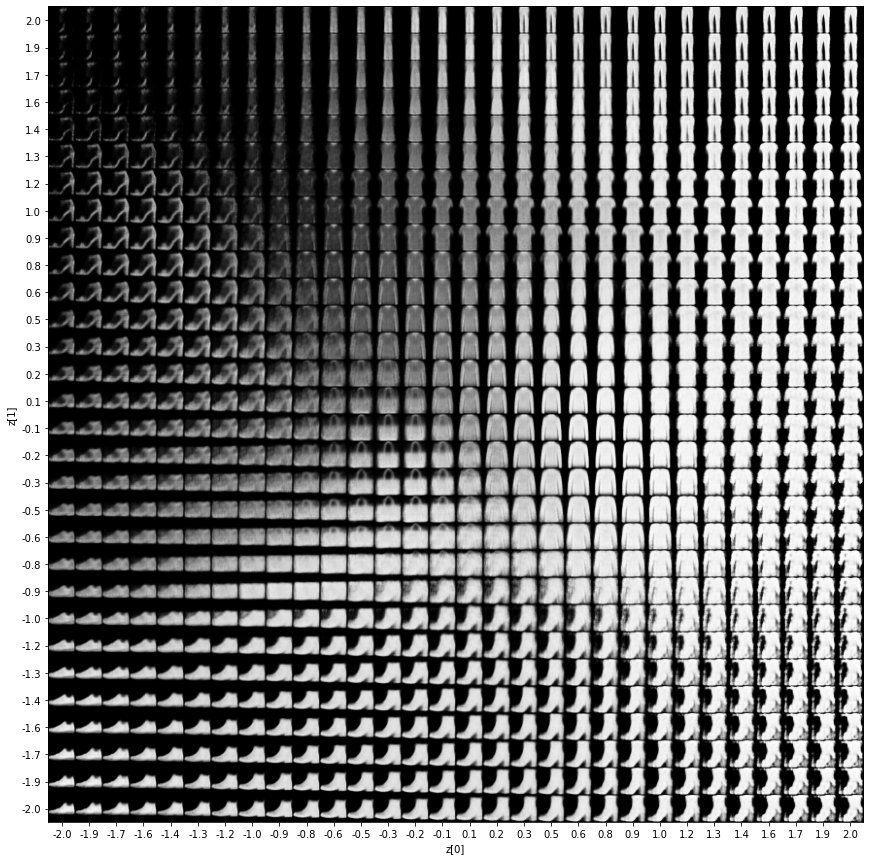

In [ ]:
import matplotlib.pyplot as plt

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

### Посмотрим на кластеры в скрытом пространстве

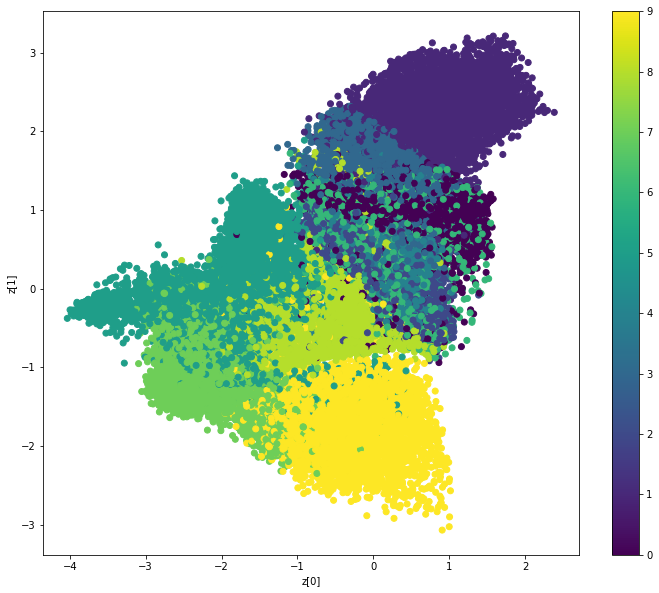

In [ ]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

Построим немного примеров генерации одежды:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

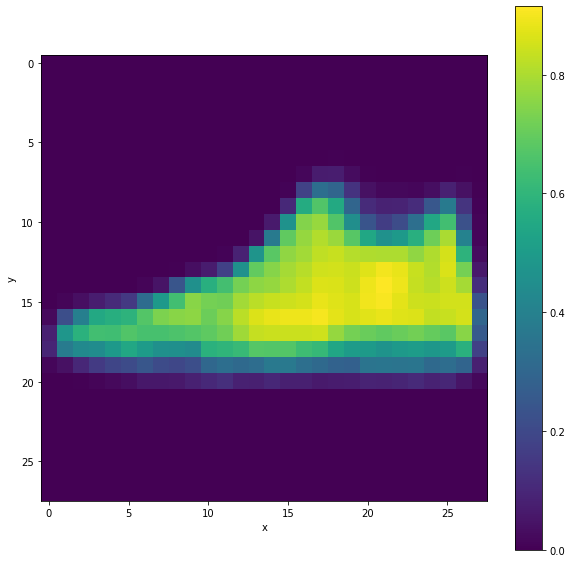

In [ ]:
def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-2, -2], 28)

## 2 Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Сделаю обзор [решения задачи коммивояжера с использованием рекуррентной нейронной сети.](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=sjvm&paperid=586&option_lang=rus) 

>Рассмотрим задачу коммивояжера для n городов. Известны стоимости $$C_{ij}$$ перемещения коммивояжера между городами $$i, j, i \neq j;$$ коммивояжер, выходя из одного города, должен посетить n − 1 других городов, заходя по одному разу в каждый, и вернуться в исходный. Требуется определить порядок обхода городов, при котором суммарная стоимость перемещений коммивояжера между городами минимальна.

>Локальный поиск с k соседями для замены ребер (k-opt) является наиболее широко
используемым эвристическим методом решения задачи коммивояжера; k-opt является
алгоритмом улучшения тура коммивояжера, где на каждом шаге k ребер текущего тура
заменяются другими ребрами так, чтобы получился более короткий тур.

>При больших размерностях задачи коммивояжера более предпочтительным является
метод, построенный на основе рекуррентной нейронной сети (в том числе при реализации на параллельных вычислительных системах), если достигаемая сетью точность решения удовлетворительна. Это требование, называемое принципом рациональной строгости и предполагающее отказ от абсолютно точного решения задачи, характерно для ситуаций, когда решение задачи необходимо получить в максимально сжатые сроки. Данная работа ставит своей целью разработку и анализ быстродействующего алгоритма приближенного решения задачи коммивояжера.

>В отличие от традиционных методов комбинаторной оптимизации рекуррентные нейронные сети Хопфилда не занимаются перебором вариантов. Сеть Хопфилда сходится к локально-оптимальному решению задачи, но промежуточные состояния нейронов образуют не допустимое решение, а приближение к нему, которое задается матрицей действительных чисел из интервала (0, 1).

>Для решения задачи используется матрица нейронов размером n × n. Задача
решается рекуррентной нейронной сетью Хопфилда–Вана, которая описывается дифференциальным уравнением:

$$\frac{∂u_{ij}(t)}{∂t} = −η(\sum\limits_{k=1}^{n}v_{ik}(t)+\sum\limits_{l=1}^{n} v_{lj}(t) − 2) − λC_{ij} \exp (- \frac{t}{\tau})$$

где $v_{ij} = f(u_{ij}(t))$, $f(u) = 1/1 + \exp(−\beta u))$, $\beta, \eta, \lambda, \tau$ — параметры сети.

>Предложен и исследован алгоритм NWTA приближенного решения задачи коммивояжера, основанный на использовании рекуррентной нейронной сети Хопфилда–Вана, модифицированного метода WTA и 2-opt. Для ускорения решения системы уравнений сети Хопфилда–Вана предложен метод частичных (префиксных) сумм. Показано, что при большом числе городов (130 и выше) алгоритм NWTA решает задачу коммивояжера существенно быстрее (на рассмотренных примерах из библиотеки TSPLIB до 24 раз), чем известный эвристический алгоритм LKH (алгоритм Лина–Кернигана–Гельсгауна), посредством которого удалось получить оптимальные маршруты для всех примеров библиотеки TSPLIB